# DGCCA clustering

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pickle
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

## preset globals

In [67]:
CANCER = 'LUAD'
DATA_DIR = './../../data/TCGA_{}/DGCCA/'.format(CANCER)
MODEL = 'DGCCA'
EXP = 'exp1'
INC_MISSING = True

if not os.path.exists('./../../results/{}/{}/models/{}'.format(CANCER,MODEL,EXP)):
    os.makedirs('./../../results/{}/{}/models/{}'.format(CANCER,MODEL,EXP))
    
if not os.path.exists('./../../results/{}/{}/embeddings/{}'.format(CANCER,MODEL,EXP)):
    os.makedirs('./../../results/{}/{}/embeddings/{}'.format(CANCER,MODEL,EXP))
    
if not os.path.exists('./../../results/{}/{}/clustering/{}'.format(CANCER,MODEL,EXP)):
    os.makedirs('./../../results/{}/{}/clustering/{}'.format(CANCER,MODEL,EXP))
    
if not os.path.exists('./../../results/{}/{}/univcoxph/{}'.format(CANCER,MODEL,EXP)):
    os.makedirs('./../../results/{}/{}/univcoxph/{}'.format(CANCER,MODEL,EXP))
    

In [69]:
# load DGCCA embeddings for 3 views - methylation, RNAseq, miRNA
embedding = np.load('./../../results/{}/{}/embeddings/embedding_dgcca_wts=_k=100_rcov=_arch=[[19924,500,100],[16630,500,100],[220,500,100]]_l1=0.001_l2=0.0001_exp=1_epoch19.embedding.npz'.format(CANCER,MODEL),
                   fix_imports=True)
embedding = embedding['G']

# load id mapping
id_mapping = pd.read_csv('./../../data/TCGA_{}/methyl_rnaseq_mirna_minmax_idmapping.tsv'.format(CANCER), sep='\t')

# load subtype information
subtypes = pd.read_csv('./../../data/TCGASubtype.20170308.tsv', sep='\t')
    
# save embedding to csv
embedding_df = pd.DataFrame(embedding)
embedding_df.index = id_mapping['sample']
embedding_df = embedding_df.rename(columns={k:'DGCCA_'+str(k+1) for k in embedding_df.columns})

# # include missing?
# if not INC_MISSING:
#     common_sample = pd.read_csv('./../../data/TCGA_{}/methyl_rnaseq_mirna_minmax_common_sample.csv'.format(CANCER), index_col=0)
#     embedding_df = embedding_df.reset_index()
#     embedding_df = embedding_df[embedding_df['sample'].isin(common_sample['x'])]
#     id_mapping = id_mapping[id_mapping['sample'].isin(embedding_df['sample'])]
#     embedding = embedding[list(embedding_df.index)]
#     embedding_df.index = embedding_df['sample']
    
# embedding_df.to_csv('./../../results/{}/{}/embeddings/{}/{}_embeddings.csv'.format(CANCER,MODEL,EXP,MODEL))

## PCA

In [70]:
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embedding)
id_mapping['PCA_1'] = embedding_pca[:,0]
id_mapping['PCA_2'] = embedding_pca[:,1]
sampleWithSubtypes = id_mapping.merge(subtypes, left_on='sample', right_on='sampleID')

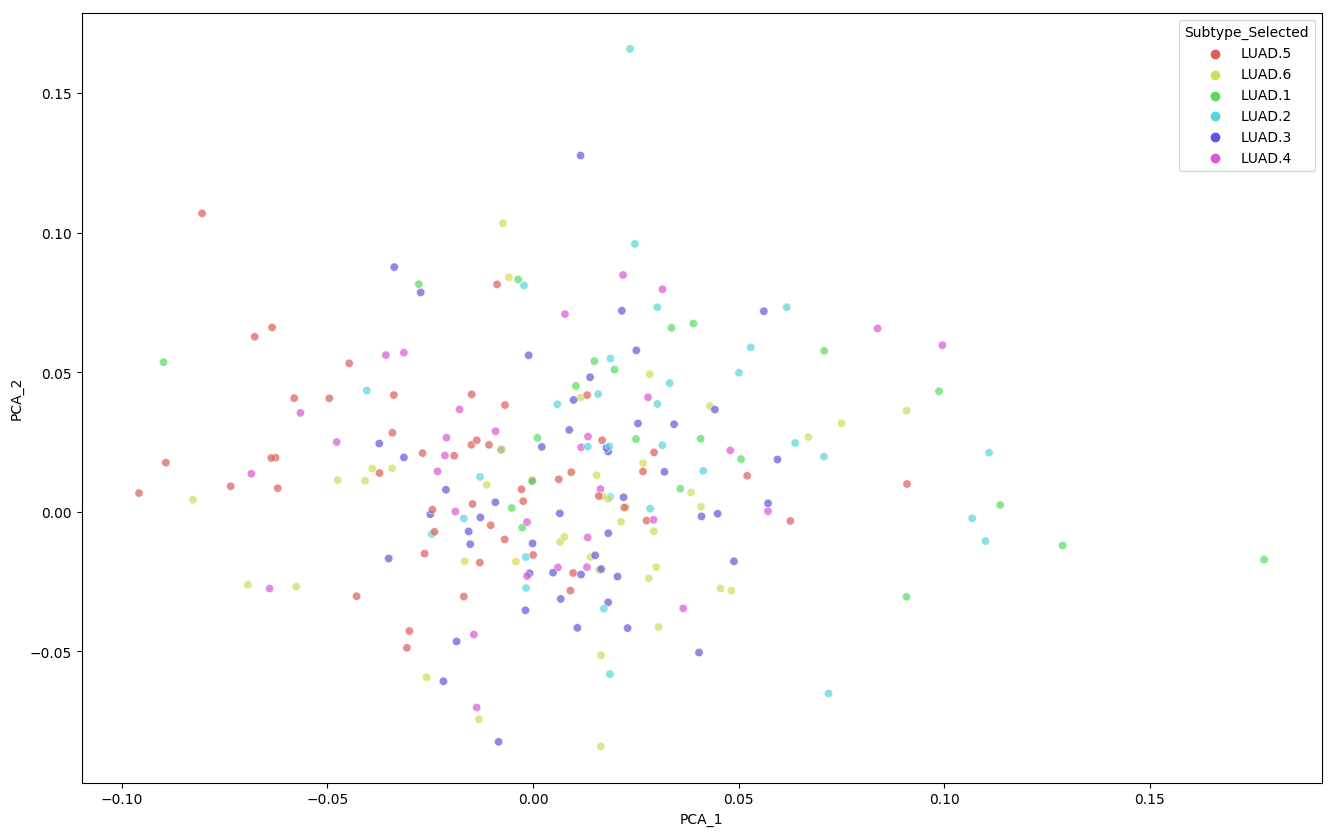

In [71]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PCA_1", y="PCA_2",
    hue="Subtype_Selected",
    palette=sns.color_palette("hls", len(sampleWithSubtypes.Subtype_Selected.unique())),
    data=sampleWithSubtypes,
    legend="full",
    alpha=0.7
)

## T-SNE

In [1]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
embedding_tsne = tsne.fit_transform(embedding)
id_mapping['TSNE_1'] = embedding_tsne[:,0]
id_mapping['TSNE_2'] = embedding_tsne[:,1]
sampleWithSubtypes = id_mapping.merge(subtypes, left_on='sample', right_on='sampleID')

NameError: name 'TSNE' is not defined

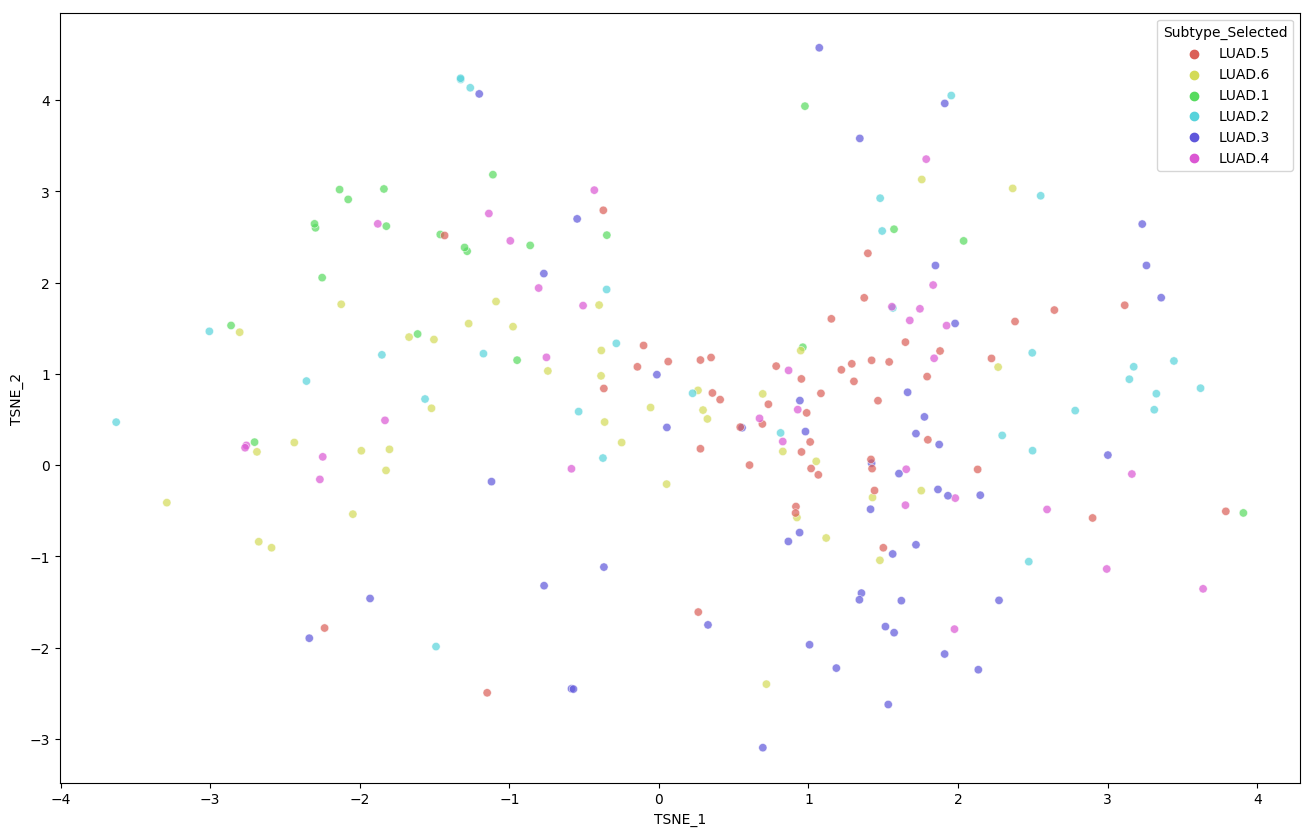

In [73]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="TSNE_1", y="TSNE_2",
    hue="Subtype_Selected",
    palette=sns.color_palette("hls", len(sampleWithSubtypes.Subtype_Selected.unique())),
    data=sampleWithSubtypes,
    legend="full",
    alpha=0.7
)

## Univariate CoxPH model (done in R)

## k-means clustering

k = 2, silhouette width = 0.015506578816059479, calinski-harabasz score = 7.3592715207497434
k = 3, silhouette width = -0.003318931813754229, calinski-harabasz score = 6.986219655388953
k = 4, silhouette width = -0.031810170588710295, calinski-harabasz score = 6.763540506372839
k = 5, silhouette width = -0.024558057955906158, calinski-harabasz score = 6.02959263937604
k = 6, silhouette width = -0.030922969256355105, calinski-harabasz score = 5.800454316895494


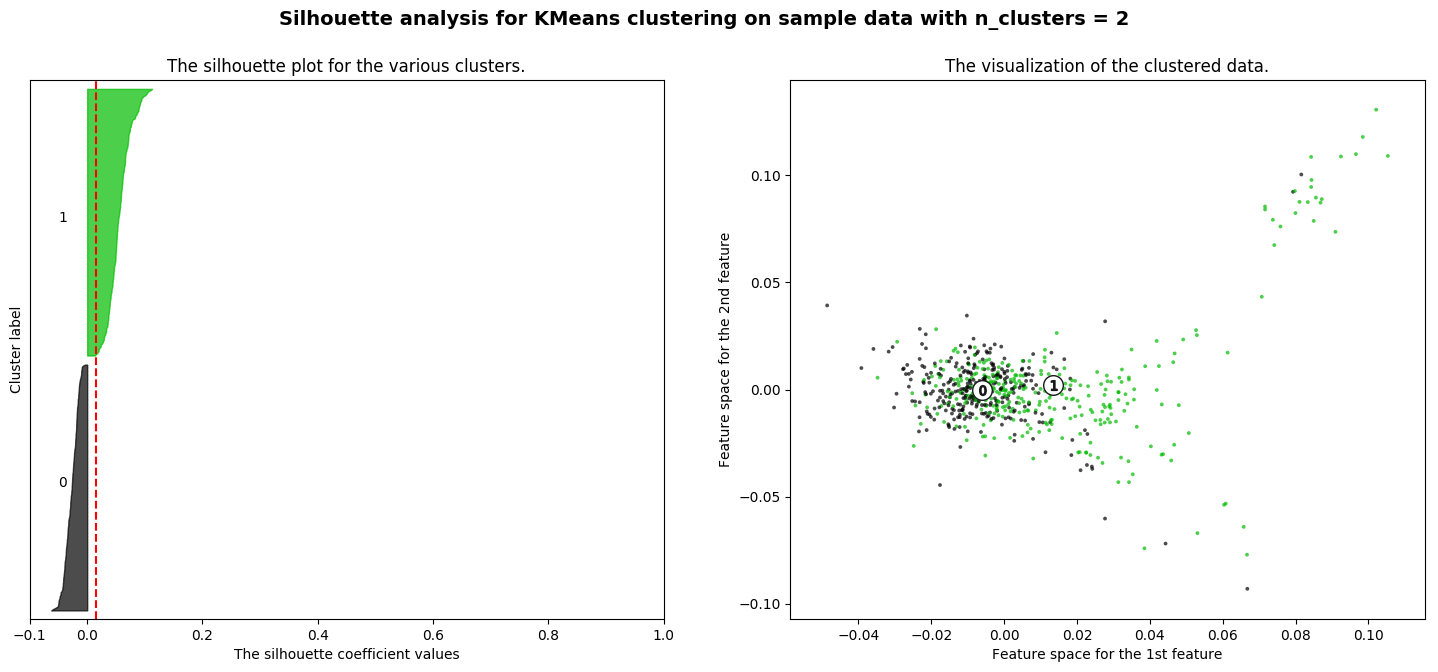

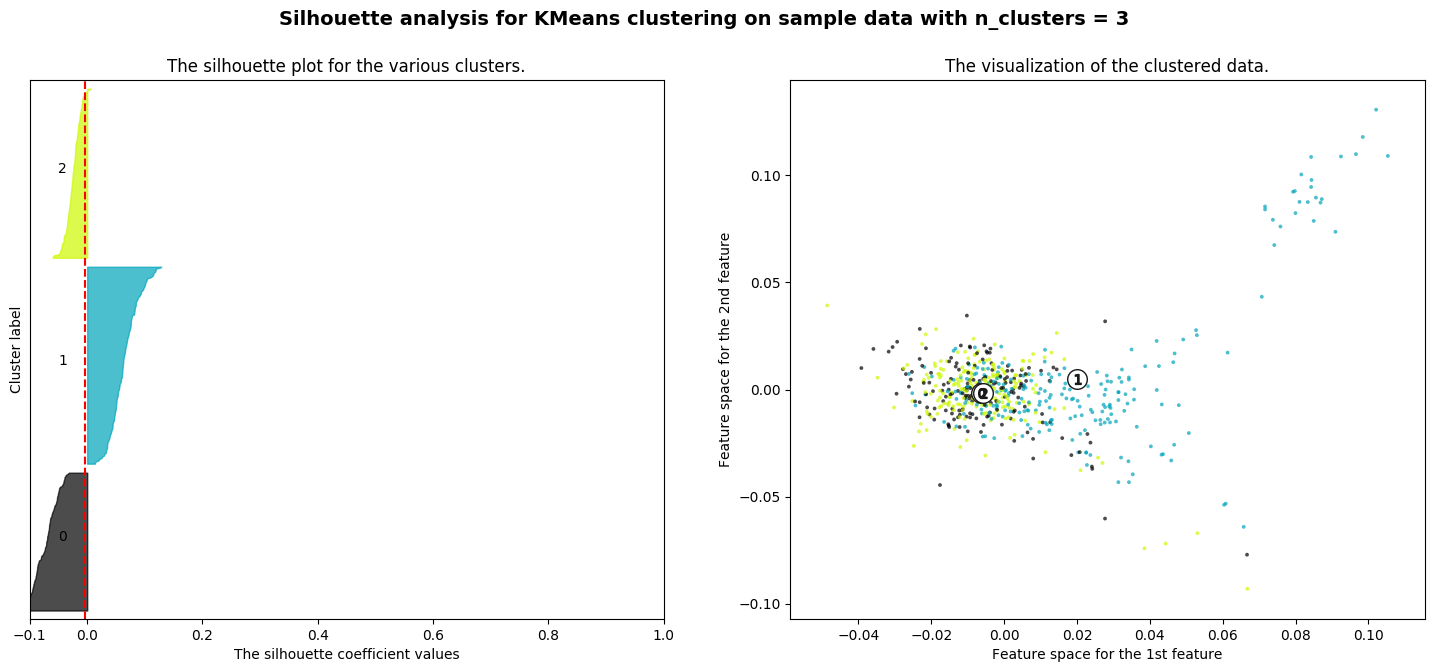

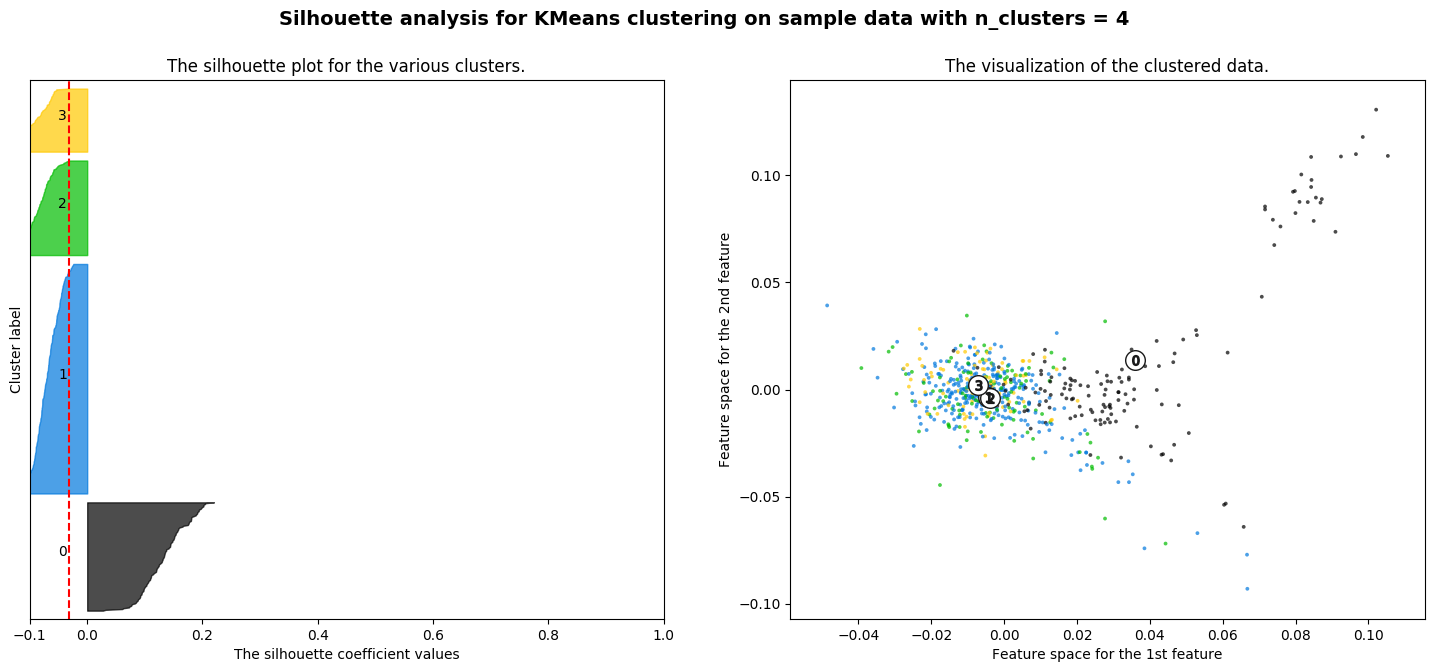

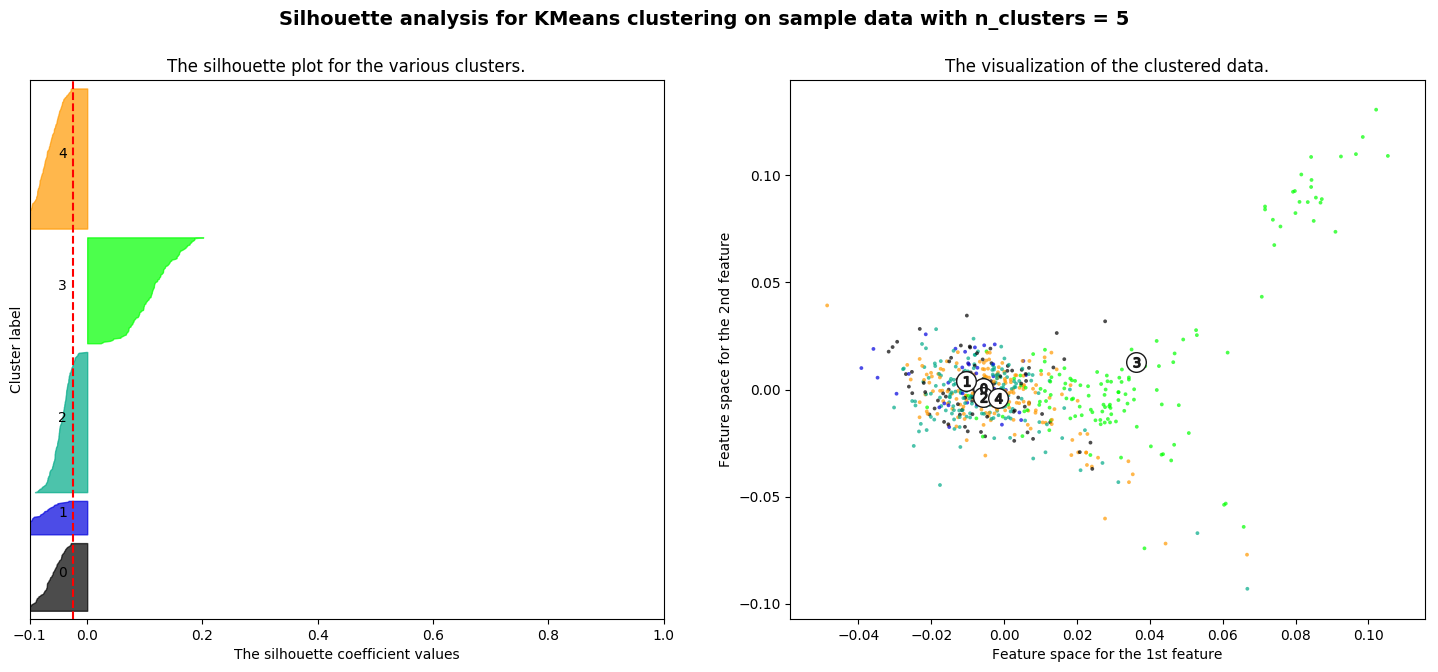

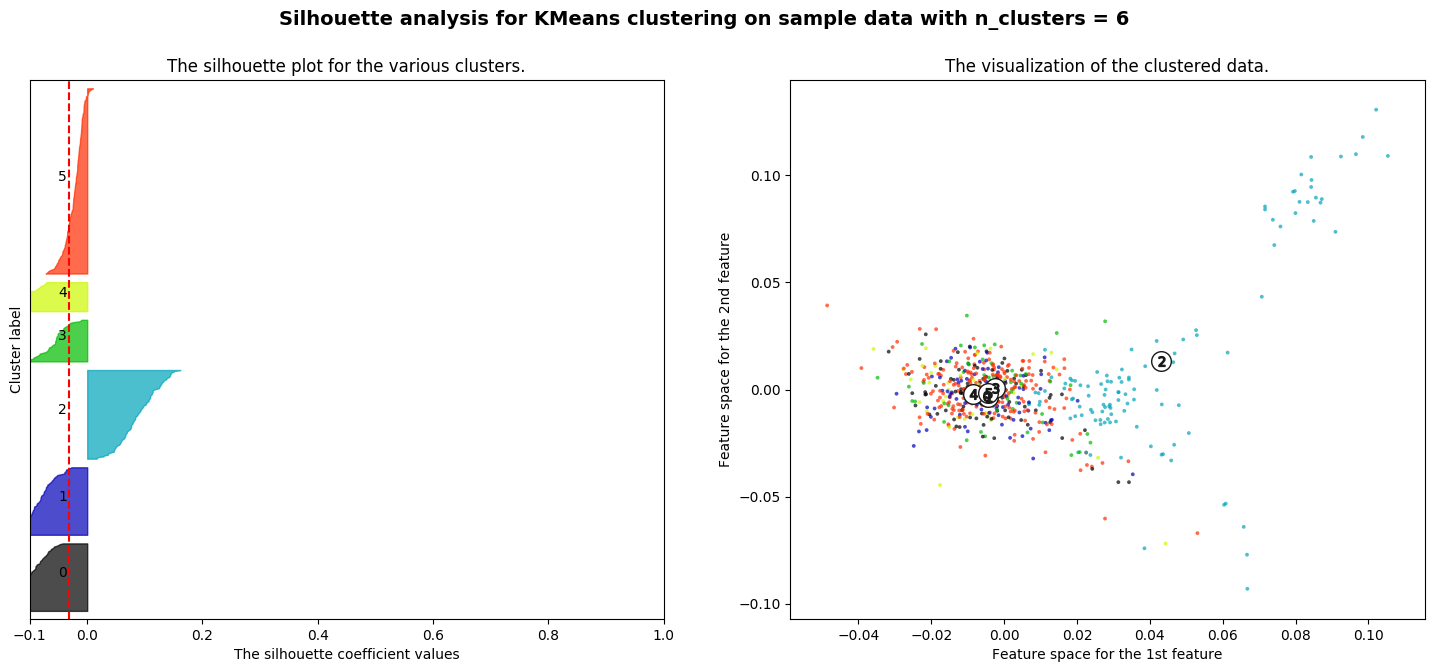

In [74]:
# using full embedding
# clustering for k = 2 to 6

models = []
clus_res = {}
clus_res['k'] = []
clus_res['silhouette'] = []
clus_res['calinski_harabasz'] = []

for k in range(2,7,1):
    model = KMeans(n_clusters=k,
                   n_init=100,
                   max_iter=2000,
                   verbose=1,
                   random_state=123,
                   n_jobs=-1
                 ).fit(embedding)
    labels = model.labels_
    sil_score = metrics.silhouette_score(embedding, labels, metric='euclidean')
    ch_score = metrics.calinski_harabasz_score(embedding, labels)
    
    print('k = {}, silhouette width = {}, calinski-harabasz score = {}'.format(k,
                                                                              sil_score,
                                                                              ch_score))
    
    clus_res['k'].append(k)
    clus_res['silhouette'].append(sil_score)
    clus_res['calinski_harabasz'].append(ch_score)
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(embedding) + (k + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     cluster_labels = clusterer.fit_predict(X)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(embedding, labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / k)
    ax2.scatter(embedding[:, 0], embedding[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = model.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()

In [75]:
# load coxph filtered embedding
embedding_coxph_df = pd.read_csv('./../../results/{}/{}/embeddings/{}/{}_embeddings_coxph.csv'.format(CANCER,MODEL,EXP,MODEL), index_col=0)

In [76]:
# include missing?
if not INC_MISSING:
    common_sample = pd.read_csv('./../../data/TCGA_{}/methyl_rnaseq_mirna_minmax_common_sample.csv'.format(CANCER), index_col=0)
    embedding_coxph_df = embedding_coxph_df.reset_index()
    embedding_coxph_df = embedding_coxph_df[embedding_coxph_df['index'].isin(common_sample['x'])]
    id_mapping = id_mapping[id_mapping['sample'].isin(embedding_coxph_df['index'])]
    embedding_coxph_df = embedding_coxph_df.set_index('index', drop=True)
    embedding_coxph = embedding_coxph_df.values[:,1:]
else:
    embedding_coxph = embedding_coxph_df.values

# embedding_coxph_df.to_csv('./../../results/{}/{}/embeddings/{}/{}_embeddings_coxph.csv'.format(CANCER,MODEL,EXP,MODEL))

k = 2, silhouette width = 0.08952263173048668, calinski-harabasz score = 59.21395018012403, time = 0.13642215728759766
k = 3, silhouette width = 0.08409932133354447, calinski-harabasz score = 54.29404199500066, time = 0.1602001190185547
k = 4, silhouette width = 0.0793239375025438, calinski-harabasz score = 50.1483602575554, time = 0.15769481658935547
k = 5, silhouette width = 0.07525665897497008, calinski-harabasz score = 47.32040279267753, time = 0.15516304969787598
k = 6, silhouette width = 0.07147462881395517, calinski-harabasz score = 45.005302068016306, time = 0.16124820709228516


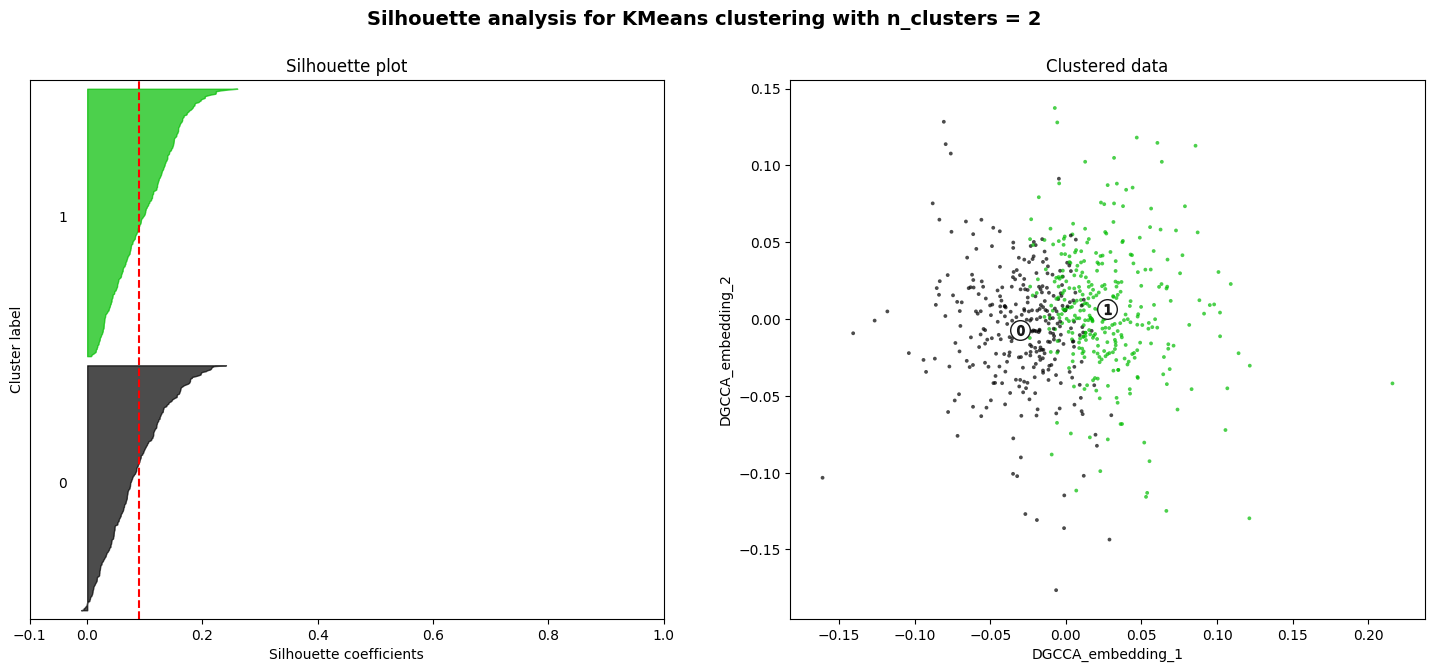

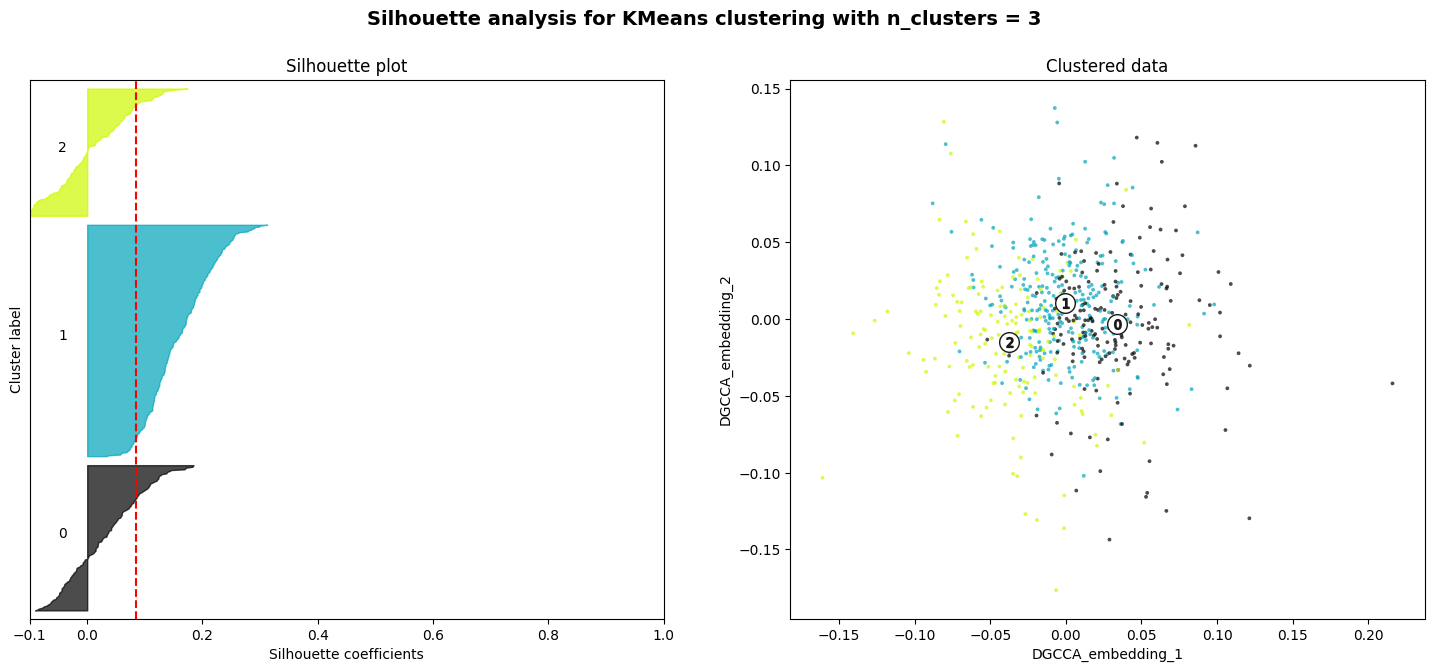

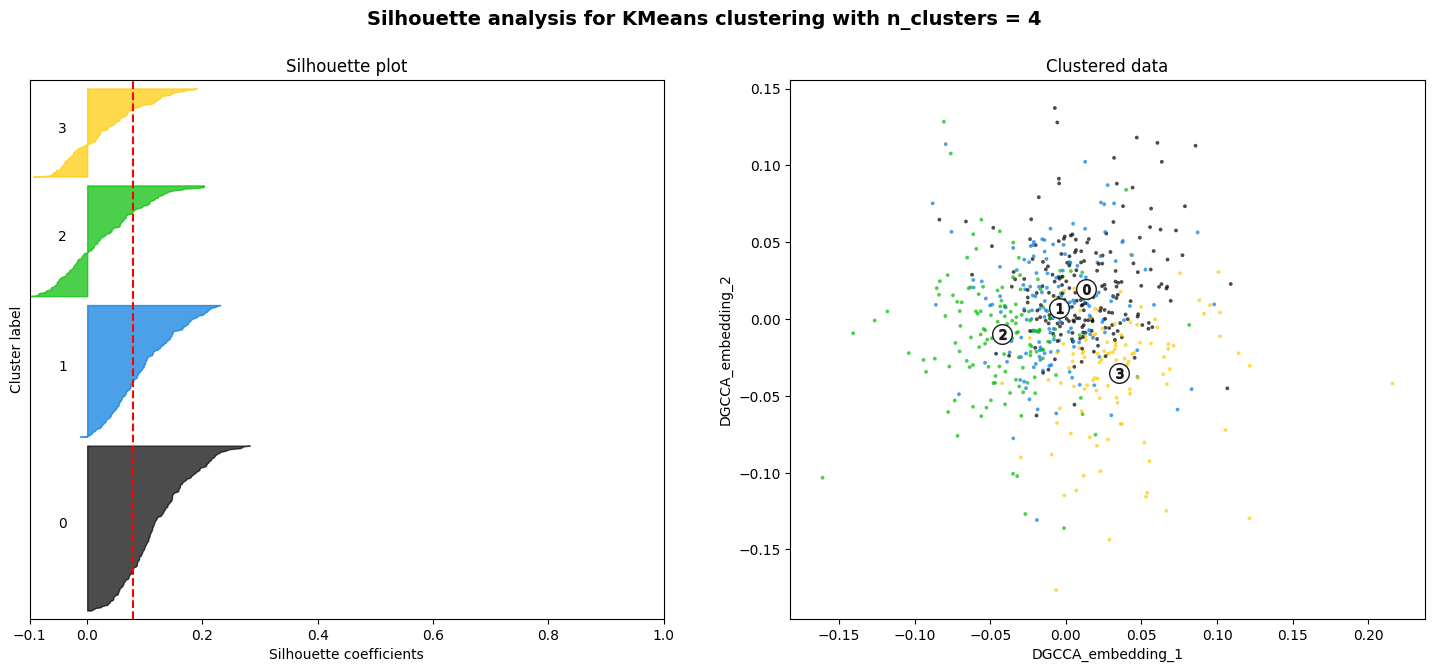

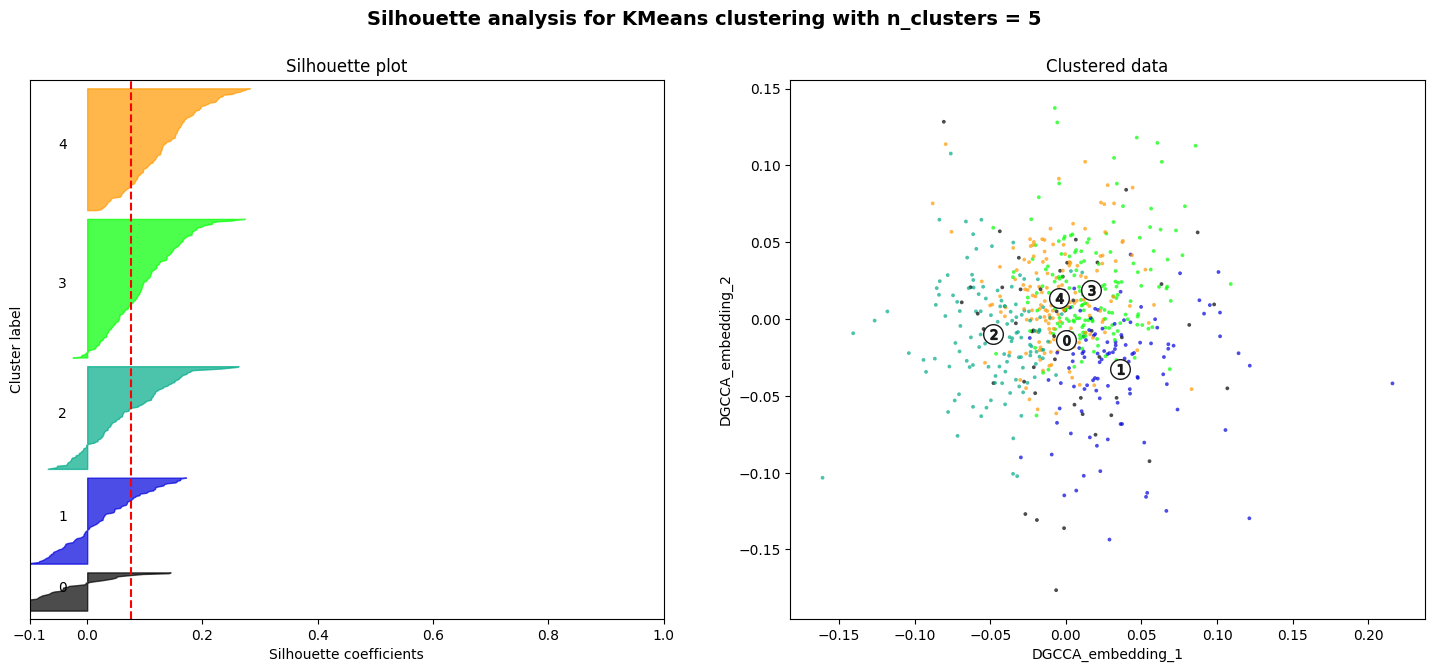

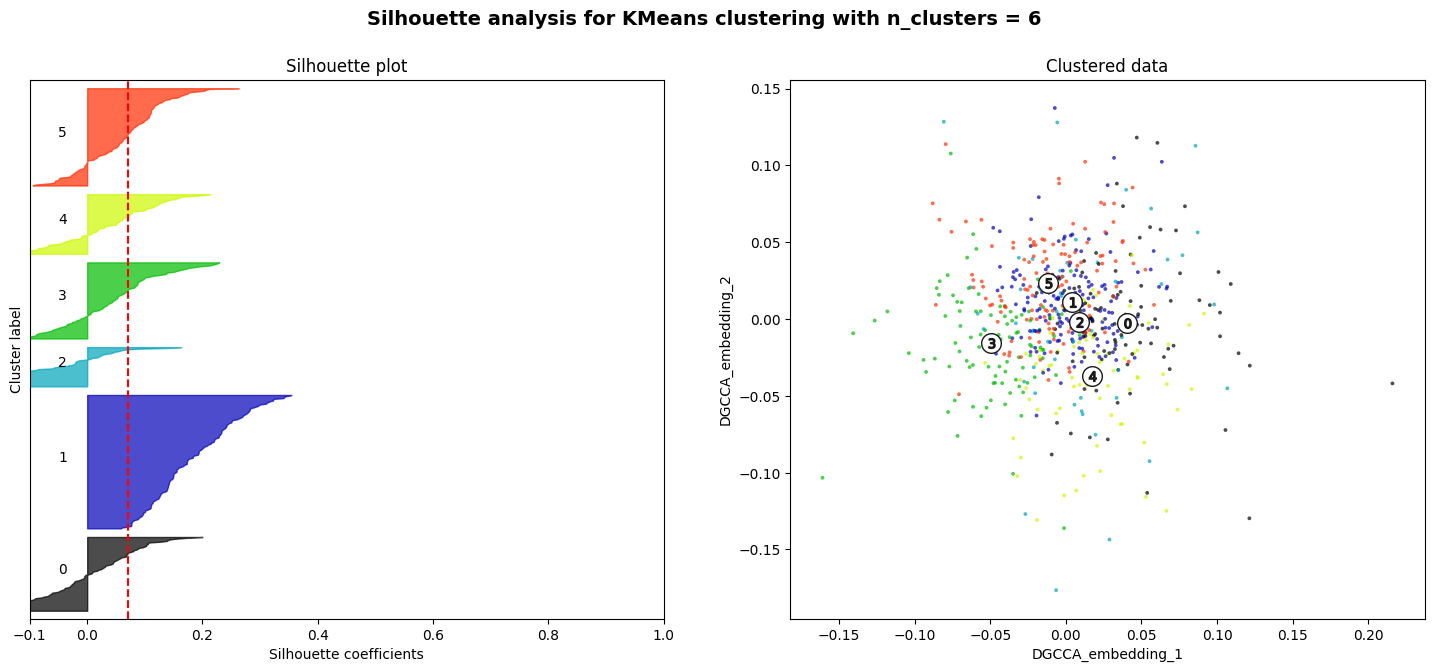

In [77]:
# using univariate coxph-filtered embeddings
# clustering for k = 2 to 6

models = []

clus_res = {}
clus_res['k'] = []
clus_res['silhouette'] = []
clus_res['calinski_harabasz'] = []


for k in range(2,7,1):
    t1 = time.time()
    model = KMeans(n_clusters=k,
                   n_init=100,
                   max_iter=2000,
                   verbose=1,
                   random_state=123,
                   n_jobs=-1
                 ).fit(embedding_coxph)
    labels = model.labels_
    sil_score = metrics.silhouette_score(embedding_coxph, labels, metric='euclidean')
    ch_score = metrics.calinski_harabasz_score(embedding_coxph, labels)
    t2 = time.time()
    print('k = {}, silhouette width = {}, calinski-harabasz score = {}, time = {}'.format(k,
                                                                              sil_score,
                                                                              ch_score,
                                                                              t2-t1))
    models.append(model)
    clus_res['k'].append(k)
    clus_res['silhouette'].append(sil_score)
    clus_res['calinski_harabasz'].append(ch_score)
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(embedding_coxph) + (k + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     cluster_labels = clusterer.fit_predict(X)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(embedding_coxph, labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("Silhouette coefficients")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / k)
    ax2.scatter(embedding_coxph[:, 0], embedding_coxph[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = model.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
        
#     ax2.set_ylim(-0.08177, -0.08178)
#     ax2.set_xlim(-0.08600, -0.086004)

    ax2.set_title("Clustered data")
    ax2.set_xlabel("DGCCA_embedding_1")
    ax2.set_ylabel("DGCCA_embedding_2")

    plt.suptitle(("Silhouette analysis for KMeans clustering "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

#     plt.savefig('./../../results/{}/{}/clustering/{}/kmeans_coxph_{}_embedding.png'.format(CANCER,MODEL,EXP,k))

In [63]:
0.12949800491333008+0.11819624900817871+0.12366056442260742+0.12672019004821777+0.12528753280639648

0.6233625411987305

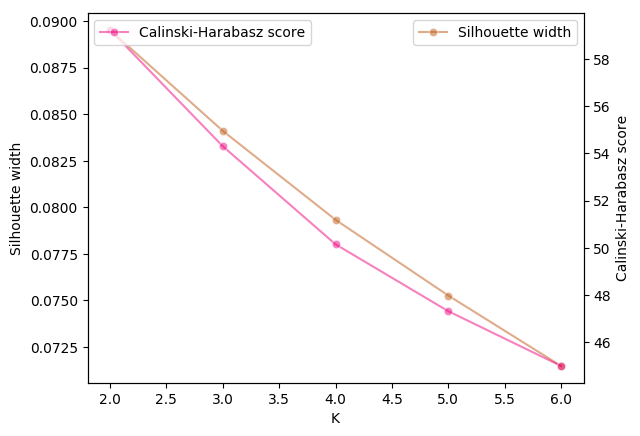

In [78]:
clus_res_df = pd.DataFrame(clus_res)
# clus_res_df = pd.melt(clus_res_df, id_vars='k')
sns.reset_defaults()
palette = iter(sns.color_palette("Accent_r",len(clus_res_df)))
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.lineplot(data=clus_res_df, x="k", y="silhouette", 
             marker = 'o', ax = ax1, color = next(palette), 
             label='Silhouette width', alpha =0.5) # plots the first set of data, and sets it to ax1. 
sns.lineplot(data=clus_res_df, x="k", y="calinski_harabasz", 
             marker = 'o', color = next(palette), ax = ax2, 
             label='Calinski-Harabasz score',alpha =0.5) # plots the second set, and sets to ax2. 

# these lines add the annotations for the plot. 
ax1.set_xlabel('K')
ax1.set_ylabel('Silhouette width')
ax2.set_ylabel('Calinski-Harabasz score')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.savefig('./../../results/{}/{}/clustering/{}/cluster_eval.png'.format(CANCER,MODEL,EXP)) # shows the plot. 

In [143]:
# with open('./../../results/LIHC/DGCCA/clustering/kmeans_results_coxph_embedding_exp12_epoch41.pkl', 'wb') as f:
#     pickle.dump(clus_res, f)
    
# with open('./../../results/LIHC/DGCCA/clustering/kmeans_models_coxph_embedding_exp12_epoch41.pkl', 'wb') as f:
#     pickle.dump(models, f)

In [435]:
id_mapping['DGCCA_cluster'] = models[4].labels_

In [79]:
id_mapping[['sample','DGCCA_cluster']].to_csv('./../../results/{}/{}/clustering/{}/cluster_assignment.csv'.format(CANCER,MODEL,EXP))

KeyError: "['DGCCA_cluster'] not in index"

In [81]:
id_mapping['DGCCA_cluster_2'] = models[0].labels_
id_mapping['DGCCA_cluster_3'] = models[1].labels_
id_mapping['DGCCA_cluster_4'] = models[2].labels_
id_mapping['DGCCA_cluster_5'] = models[3].labels_
id_mapping['DGCCA_cluster_6'] = models[4].labels_

In [82]:
id_mapping[['sample',
            'DGCCA_cluster_2',
            'DGCCA_cluster_3',
            'DGCCA_cluster_4',
            'DGCCA_cluster_5',
            'DGCCA_cluster_6'
           ]].to_csv('./../../results/{}/{}/clustering/{}/cluster_assignment.csv'.format(CANCER,MODEL,EXP))

In [66]:
models[0].labels_.shape

(438,)